
# Python Analysis Demo
### Billy Fryer based on the work of Andrew Steenkamer
### May 30, 2025

*Total distance traveled vs. straight line distance to make a fly out*

**EXAMPLE**: Consider fly ball routes for a single player

### Load in Libraries

In [1]:
# Package Installation
# !pip install pandas
# !pip install sportypy

In [2]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.dataset as pads
import pyarrow.csv as pacsv
import sportypy

### Load in Game Info

In [3]:
# Import the function to read in the data from the Starter File
from SMT_Data_Starter_2025 import readDataSubset

# Read in the Game Info Data and filter to 1st year
game_info_subset = readDataSubset('game_info')
game_info = game_info_subset.to_table(filter = (pads.field('year') == "year_1")).to_pandas()


# Read in the Game Events Data and filter to 1st year
game_events_subset = readDataSubset('game_events')
game_events = game_events_subset.to_table(filter = (pads.field('year') == "year_1")).to_pandas()

### Choose a Player
Limit to center fielders, choose the player that’s been in the most plays.

**Using game_info, how many plays are each center fielder in?**

In [4]:
# Counts the number of unique values and their frequencues
cf_play_count = game_info.value_counts('center_field')
print(cf_play_count)

# Just for team QEA?
# filtered = cf_play_count.loc[cf_play_count.index.str.startswith('QEA')]
# print(filtered)

# How many outfielders does team QEA have?
# print(len(cf_play_count_filtered))

# Python is zero-indexed, so get the first value
player1 = cf_play_count.keys()[0]
player1

center_field
RZQ-0274    5196
YJD-0193    2585
YJD-0338    2322
QEA-0235    1962
QEA-0252    1287
            ... 
REC-1999      11
RZQ-0417       3
MCJ-1010       2
YJD-0234       1
RZQ-0005       1
Name: count, Length: 92, dtype: int64


'RZQ-0274'

**How many games did player1 play in?**

In [5]:
# Filter to where the cf is player 1, then pull the number of unique game_str
player1_game_info  = game_info[game_info['center_field'] == player1].game_str.unique()
# Finally check the length
len(player1_game_info )

36

### Find the Plays we want

**In which games did player1 make a fly ball catch and how many total catches did he have?**

1) Pull information from game_events

2) Look for sequences where a ball is put in play, then caught by the center fielder.

| player_position | event_code |
| ---------------: | ----------: |
| 10 (batter)     | 4 (ball in play) |
| 8  (center fielder) | 2 (ball acquired) |

3) Are the catches by player1 and not the other team's center fielder?

Gather each play where there was a ball hit into play immediately followed by a CF catch.

In [17]:
# Filter game_events to only where we have the CF acquiring the ball
CFCatches = game_events[(game_events['event_code'] == 2) & (game_events['player_position'] == 8) & 
                       # And the previous event was a ball put in play by the batter
                        (game_events['event_code'].shift(1) == 4) & (game_events['player_position'].shift(1) == 10)]

# Filter down game_info to only player1
Player1Plays = game_info

# Merge the CFCatches with Player1Plays with an inner join to have Player1 CF Catches
Player1Catches = pd.merge(CFCatches, Player1Plays, on=["game_str", "play_per_game"], how="inner")

# Only take the game_str, play_id, and play_per_game
Player1Catches = Player1Catches[["game_str", "play_id", "play_per_game","center_field"]]

# Print out the first few rows
Player1Catches.head(5)

game_str  play_id  play_per_game center_field
0  y1_d070_ACN_QEA       45             45     ACN-1147
1  y1_d070_ACN_QEA       48             48     ACN-1147
2  y1_d070_ACN_QEA      124            124     QEA-0365
3  y1_d070_ACN_QEA      196            196     ACN-1147
4  y1_d071_ACN_QEA       35             35     ACN-1147

In [18]:
CFCatches.head(5)

game_str  play_id at_bat  play_per_game  timestamp  \
61    y1_d069_ACN_QEA       18     33             18     592003   
522   y1_d069_ACN_QEA      128     67            128    5070694   
804   y1_d070_ACN_QEA       45      9             45    1281887   
817   y1_d070_ACN_QEA       48     10             48    1390837   
1133  y1_d070_ACN_QEA      124     29            124    3921137   

      player_position  event_code home_team away_team    year      day  
61                  8           2       QEA       ACN  year_1  day_069  
522                 8           2       QEA       ACN  year_1  day_069  
804                 8           2       QEA       ACN  year_1  day_070  
817                 8           2       QEA       ACN  year_1  day_070  
1133                8           2       QEA       ACN  year_1  day_070

### Calculating Hang Time and Start/End Timestamps

**How do we determine the hang time for distance traveled?**

*Assumption*: player1 starts moving as soon as the ball leaves the bat.

In [19]:
# Lets look at all the times when the ball was put into play
HitEvents = game_events[game_events["event_code"] == 4]

# left join all CF catches to get ending timestamp for player1 catches
Player1CatchesWithTimestamps = pd.merge(Player1Catches, CFCatches, on=["game_str", "play_per_game"], how="left")
Player1CatchesWithTimestamps = Player1CatchesWithTimestamps[["game_str", "play_id_x", "play_per_game", "timestamp","center_field"]]
Player1CatchesWithTimestamps = Player1CatchesWithTimestamps.rename(columns={'timestamp':'end_time', 'play_id_x':'play_id'})


# left join all hit events to get starting timestamp for player1 catches
Player1CatchesWithTimestamps = pd.merge(Player1CatchesWithTimestamps, HitEvents, on=["game_str", "play_per_game"], how="left")
Player1CatchesWithTimestamps = Player1CatchesWithTimestamps[["game_str", "play_id_x", "play_per_game", "end_time", "timestamp","center_field"]]
Player1CatchesWithTimestamps = Player1CatchesWithTimestamps.rename(columns={'timestamp':'start_time', 'play_id_x':'play_id'})

# Calculate hang_time
Player1CatchesWithTimestamps['hang_time'] = (Player1CatchesWithTimestamps['end_time'] - Player1CatchesWithTimestamps['start_time']) / 1000

# Initialize variables for straight line distance, total distance traveled and route efficiency
Player1CatchesWithTimestamps['d_straight'] = 0
Player1CatchesWithTimestamps['d_total'] = 0
Player1CatchesWithTimestamps['route_eff'] = 0

Player1CatchesWithTimestamps.head(5)

game_str  play_id  play_per_game  end_time  start_time center_field  \
0  y1_d070_ACN_QEA       45             45   1281887     1278587     ACN-1147   
1  y1_d070_ACN_QEA       48             48   1390837     1384837     ACN-1147   
2  y1_d070_ACN_QEA      124            124   3921137     3917937     QEA-0365   
3  y1_d070_ACN_QEA      196            196   6366587     6362587     ACN-1147   
4  y1_d071_ACN_QEA       35             35   1060115     1054065     ACN-1147   

   hang_time  d_straight  d_total  route_eff  
0       3.30           0        0          0  
1       6.00           0        0          0  
2       3.20           0        0          0  
3       4.00           0        0          0  
4       6.05           0        0          0

### Find Player Distance Information

1) Pull information from player_pos, filtered for Player1

**NOTE: Since player_pos is large, we want to filter it down immediately**

In [20]:
# Read in the player_pos data set
player_position_subset = readDataSubset('player_pos')

# Filter down to year_1 and only cf
player_position = player_position_subset.to_table(filter = (pads.field('year') == "year_1") & (pads.field('player_position') == 8)).to_pandas()

print(player_position.head())


          game_str  play_id  timestamp  player_position  field_x   field_y  \
0  y1_d069_ACN_QEA        1      14853                8  -6.7491  313.4958   
1  y1_d069_ACN_QEA        1      14903                8  -6.7491  313.4958   
2  y1_d069_ACN_QEA        1      14953                8  -6.7491  313.4958   
3  y1_d069_ACN_QEA        1      15003                8  -6.7491  313.4958   
4  y1_d069_ACN_QEA        1      15053                8  -6.7491  313.4958   

  home_team away_team    year      day  
0       QEA       ACN  year_1  day_069  
1       QEA       ACN  year_1  day_069  
2       QEA       ACN  year_1  day_069  
3       QEA       ACN  year_1  day_069  
4       QEA       ACN  year_1  day_069  


2) Add data frame columns for straight line distance and total distance traveled by looping through each play:
   
   STRAIGHT LINE DISTANCE: [x,y] distance between player1 location at start and end times
   
   TOTAL DISTANCE TRAVELED: the sum of [x,y] distances by timestamp between start and end times
   
   ROUTE EFFICIENCY: (straight line distance)/(total distance traveled)
   
   (N.B. - This is considered a suspect metric. We'll see why in a minute.)

In [21]:
# Python defaults to raising a warning when we try to use chained assignment.
# We're doing that intentionally so we're turning that warning off
pd.options.mode.chained_assignment = None

# when possible avoid for loops due to slow processing, but we're showing a different approach  
for play in range(len(Player1CatchesWithTimestamps)):
    
    # Print which iteration we are on to follow progress of for loop
    print(play+1, "/", len(Player1CatchesWithTimestamps)) 
    
    # Filter the player positioning data for the center field route
    CFRoute = player_position[(player_position['game_str'] == Player1CatchesWithTimestamps['game_str'].iloc[play]) &
                              (player_position['play_id'] == Player1CatchesWithTimestamps['play_id'].iloc[play]) &
                              (player_position['player_position'] == 8) &
                              (player_position['timestamp'] >= Player1CatchesWithTimestamps['start_time'].iloc[play]) &
                              (player_position['timestamp'] <= Player1CatchesWithTimestamps['end_time'].iloc[play])]
    
    # Sort by timestamp
    CFRoute = CFRoute.sort_values('timestamp')
    
    # Finding the index of the max and min timestamps to calculate straightline distance
    StraightLineDist = np.sqrt((CFRoute['field_x'][CFRoute['timestamp'].idxmax()] - CFRoute['field_x'][CFRoute['timestamp'].idxmin()])**2. + 
                               (CFRoute['field_y'][CFRoute['timestamp'].idxmax()] - CFRoute['field_y'][CFRoute['timestamp'].idxmin()])**2.)
    
    ActualDistDF = CFRoute
    
    # Calculates the difference between the current row and previous row
    ActualDistDF['x_diff'] = ActualDistDF['field_x'].diff()
    ActualDistDF['y_diff'] = ActualDistDF['field_y'].diff()
    
    # For rows representing when the ball is hit, set that change in location to 0
    ActualDistDF['x_diff'].iloc[0] = 0
    ActualDistDF['y_diff'].iloc[0] = 0
    
    # Calculates the euclidean distance at each timestamp step
    ActualDistDF['stepwise_dist'] = np.sqrt(ActualDistDF['x_diff']**2. + ActualDistDF['y_diff']**2.)
    ActualDist = np.sum(ActualDistDF['stepwise_dist'])

    # In our new data frame, add these values to 3 columns: straight line distance, total distance traveled, route efficiency
    Player1CatchesWithTimestamps['d_straight'].iloc[play] = StraightLineDist
    Player1CatchesWithTimestamps['d_total'].iloc[play] = ActualDist
    Player1CatchesWithTimestamps['route_eff'].iloc[play] = StraightLineDist/ActualDist

1 / 598
2 / 598
3 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

4 / 598
5 / 598
6 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

7 / 598
8 / 598
9 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

10 / 598
11 / 598
12 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

13 / 598
14 / 598
15 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

16 / 598
17 / 598
18 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

19 / 598
20 / 598
21 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

22 / 598
23 / 598
24 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

25 / 598
26 / 598
27 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

28 / 598
29 / 598
30 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

31 / 598
32 / 598
33 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

34 / 598
35 / 598
36 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

37 / 598
38 / 598
39 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

40 / 598
41 / 598
42 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

43 / 598
44 / 598
45 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

46 / 598
47 / 598
48 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

49 / 598
50 / 598
51 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

52 / 598
53 / 598
54 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

55 / 598
56 / 598
57 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

58 / 598
59 / 598
60 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

61 / 598
62 / 598
63 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

64 / 598
65 / 598
66 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

67 / 598
68 / 598
69 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

70 / 598
71 / 598
72 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

73 / 598
74 / 598
75 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

76 / 598
77 / 598
78 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

79 / 598
80 / 598
81 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

82 / 598
83 / 598
84 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

85 / 598
86 / 598
87 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

88 / 598
89 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

90 / 598
91 / 598
92 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

93 / 598
94 / 598
95 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

96 / 598
97 / 598
98 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

99 / 598
100 / 598
101 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

102 / 598
103 / 598
104 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

105 / 598
106 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

107 / 598
108 / 598
109 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

110 / 598
111 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

112 / 598
113 / 598
114 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

115 / 598
116 / 598
117 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

118 / 598
119 / 598
120 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

121 / 598
122 / 598
123 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

124 / 598
125 / 598
126 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

127 / 598
128 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

129 / 598
130 / 598
131 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

132 / 598
133 / 598
134 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

135 / 598
136 / 598
137 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

138 / 598
139 / 598
140 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

141 / 598
142 / 598
143 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

144 / 598
145 / 598
146 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

147 / 598
148 / 598
149 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

150 / 598
151 / 598
152 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

153 / 598
154 / 598
155 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

156 / 598
157 / 598
158 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

159 / 598
160 / 598
161 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

162 / 598
163 / 598
164 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

165 / 598
166 / 598
167 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

168 / 598
169 / 598
170 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

171 / 598
172 / 598
173 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

174 / 598
175 / 598
176 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

177 / 598
178 / 598
179 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

180 / 598
181 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

182 / 598
183 / 598
184 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

185 / 598
186 / 598
187 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

188 / 598
189 / 598
190 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

191 / 598
192 / 598
193 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

194 / 598
195 / 598
196 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

197 / 598
198 / 598
199 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

200 / 598
201 / 598
202 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

203 / 598
204 / 598
205 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

206 / 598
207 / 598
208 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

209 / 598
210 / 598
211 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

212 / 598
213 / 598
214 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

215 / 598
216 / 598
217 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

218 / 598
219 / 598
220 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

221 / 598
222 / 598
223 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

224 / 598
225 / 598
226 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

227 / 598
228 / 598
229 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

230 / 598
231 / 598
232 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

233 / 598
234 / 598
235 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

236 / 598
237 / 598
238 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

239 / 598
240 / 598
241 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

242 / 598
243 / 598
244 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

245 / 598
246 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

247 / 598
248 / 598
249 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

250 / 598
251 / 598
252 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

253 / 598
254 / 598
255 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

256 / 598
257 / 598
258 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

259 / 598
260 / 598
261 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

262 / 598
263 / 598
264 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

265 / 598
266 / 598
267 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

268 / 598
269 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

270 / 598
271 / 598
272 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

273 / 598
274 / 598
275 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

276 / 598
277 / 598
278 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

279 / 598
280 / 598
281 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

282 / 598
283 / 598
284 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

285 / 598
286 / 598
287 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

288 / 598
289 / 598
290 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

291 / 598
292 / 598
293 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

294 / 598
295 / 598
296 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

297 / 598
298 / 598
299 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

300 / 598
301 / 598
302 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

303 / 598
304 / 598
305 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

306 / 598
307 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

308 / 598
309 / 598
310 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

311 / 598
312 / 598
313 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

314 / 598
315 / 598
316 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

317 / 598
318 / 598
319 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

320 / 598
321 / 598
322 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

323 / 598
324 / 598
325 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

326 / 598
327 / 598
328 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

329 / 598
330 / 598
331 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

332 / 598
333 / 598
334 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

335 / 598
336 / 598
337 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

338 / 598
339 / 598
340 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

341 / 598
342 / 598
343 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

344 / 598
345 / 598
346 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

347 / 598
348 / 598
349 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

350 / 598
351 / 598
352 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

353 / 598
354 / 598
355 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

356 / 598
357 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

358 / 598
359 / 598
360 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

361 / 598
362 / 598
363 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

364 / 598
365 / 598
366 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

367 / 598
368 / 598
369 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

370 / 598
371 / 598
372 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

373 / 598
374 / 598
375 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

376 / 598
377 / 598
378 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

379 / 598
380 / 598
381 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

382 / 598
383 / 598
384 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

385 / 598
386 / 598
387 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

388 / 598
389 / 598
390 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

391 / 598
392 / 598
393 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

394 / 598
395 / 598
396 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

397 / 598
398 / 598
399 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

400 / 598
401 / 598
402 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

403 / 598
404 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

405 / 598
406 / 598
407 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

408 / 598
409 / 598
410 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

411 / 598
412 / 598
413 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

414 / 598
415 / 598
416 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

417 / 598
418 / 598
419 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

420 / 598
421 / 598
422 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

423 / 598
424 / 598
425 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

426 / 598
427 / 598
428 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

429 / 598
430 / 598
431 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

432 / 598
433 / 598
434 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

435 / 598
436 / 598
437 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

438 / 598
439 / 598
440 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

441 / 598
442 / 598
443 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

444 / 598
445 / 598
446 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

447 / 598
448 / 598
449 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

450 / 598
451 / 598
452 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

453 / 598
454 / 598
455 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

456 / 598
457 / 598
458 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

459 / 598
460 / 598
461 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

462 / 598
463 / 598
464 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

465 / 598
466 / 598
467 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

468 / 598
469 / 598
470 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

471 / 598
472 / 598
473 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

474 / 598
475 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

476 / 598
477 / 598
478 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

479 / 598
480 / 598
481 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

482 / 598
483 / 598
484 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

485 / 598
486 / 598
487 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

488 / 598
489 / 598
490 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

491 / 598
492 / 598
493 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

494 / 598
495 / 598
496 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

497 / 598
498 / 598
499 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

500 / 598
501 / 598
502 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

503 / 598
504 / 598
505 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

506 / 598
507 / 598
508 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

509 / 598
510 / 598
511 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

512 / 598
513 / 598
514 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

515 / 598
516 / 598
517 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

518 / 598
519 / 598
520 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

521 / 598
522 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

523 / 598
524 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

525 / 598
526 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

527 / 598
528 / 598
529 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

530 / 598
531 / 598
532 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

533 / 598
534 / 598
535 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

536 / 598
537 / 598
538 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

539 / 598
540 / 598
541 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

542 / 598
543 / 598
544 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

545 / 598
546 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

547 / 598
548 / 598
549 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

550 / 598
551 / 598
552 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

553 / 598
554 / 598
555 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

556 / 598
557 / 598
558 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

559 / 598
560 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

561 / 598
562 / 598
563 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

564 / 598
565 / 598
566 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

567 / 598
568 / 598
569 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

570 / 598
571 / 598
572 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

573 / 598
574 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

575 / 598
576 / 598
577 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

578 / 598
579 / 598
580 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

581 / 598
582 / 598
583 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

584 / 598
585 / 598
586 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

587 / 598
588 / 598
589 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

590 / 598
591 / 598
592 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

593 / 598
594 / 598
595 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

596 / 598
597 / 598
598 / 598


C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ActualDistDF['x_diff'].iloc[0] = 0
C:\Users\mla21\AppData\Local\Temp\ipykernel_24640\2119818479.py:33: FutureWarning: ChainedAs

In [22]:
# Print the Data frame
Player1CatchesWithTimestamps.head(5)

game_str  play_id  play_per_game  end_time  start_time center_field  \
0  y1_d070_ACN_QEA       45             45   1281887     1278587     ACN-1147   
1  y1_d070_ACN_QEA       48             48   1390837     1384837     ACN-1147   
2  y1_d070_ACN_QEA      124            124   3921137     3917937     QEA-0365   
3  y1_d070_ACN_QEA      196            196   6366587     6362587     ACN-1147   
4  y1_d071_ACN_QEA       35             35   1060115     1054065     ACN-1147   

   hang_time  d_straight    d_total  route_eff  
0       3.30   32.349912  32.850574   0.984759  
1       6.00   51.892470  61.562647   0.842921  
2       3.20   32.697107  33.066236   0.988837  
3       4.00   53.123101  53.634149   0.990472  
4       6.05   46.910212  52.663956   0.890746

### Using Visuals to Answer Questions about Player1

**1) How does hang time correspond to straight line distance?**

**2) How does route efficiency correspond to hang time?**

**3) How does route efficiency correspond to straight line distance?**

**4) How does route efficiency correspond to straight-line speed (d_straight/hang_time)?**

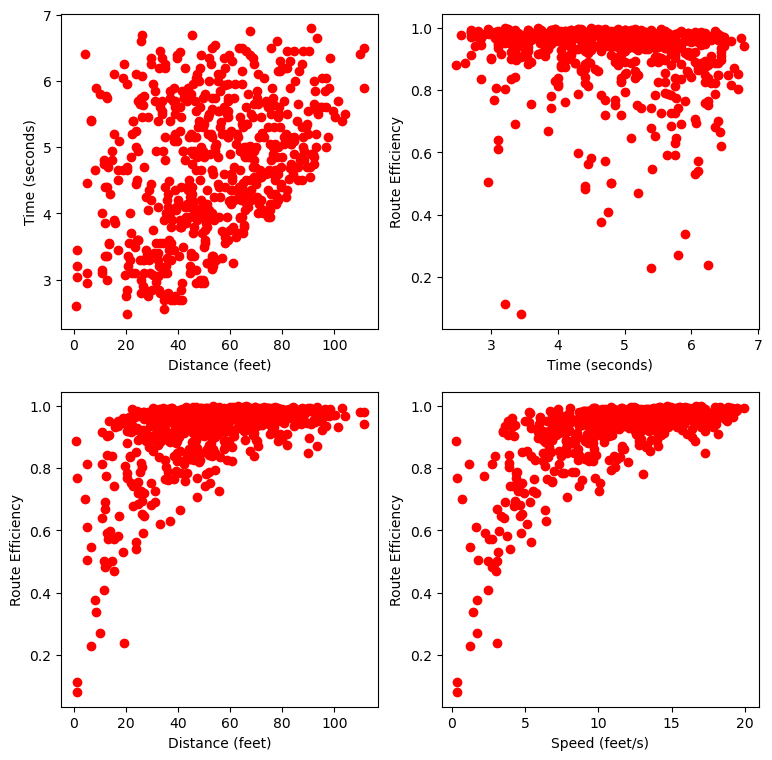

In [23]:
# Set up dimenstions of plotting figure, a 2x2 grid with each plot being 9 in x 9 in
fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2, 2, figsize = (9, 9))


ax1.scatter(Player1CatchesWithTimestamps['d_straight'], Player1CatchesWithTimestamps['hang_time'], c="red")
ax1.set_xlabel("Distance (feet)")
ax1.set_ylabel("Time (seconds)")

ax2.scatter(Player1CatchesWithTimestamps['hang_time'], Player1CatchesWithTimestamps['route_eff'], c="red")
ax2.set_xlabel("Time (seconds)")
ax2.set_ylabel("Route Efficiency")

ax3.scatter(Player1CatchesWithTimestamps['d_straight'], Player1CatchesWithTimestamps['route_eff'], c="red")
ax3.set_xlabel("Distance (feet)")
ax3.set_ylabel("Route Efficiency")

ax4.scatter(Player1CatchesWithTimestamps['d_straight']/Player1CatchesWithTimestamps['hang_time'], Player1CatchesWithTimestamps['route_eff'], c="red")
ax4.set_xlabel("Speed (feet/s)")
ax4.set_ylabel("Route Efficiency")
plt.show()

### Conclusion

*ROUTE EFFICIENCY SUFFERS FROM SELECTION BIAS.*

*"HARDER" CATCHES ONLY OCCUR WHEN PLAYERS TAKE MORE EFFICIENT ROUTES.*

# Play Animation!

Thanks to previous work done by Eddie Dew from Charlotte, we have play animation code in Python as well!

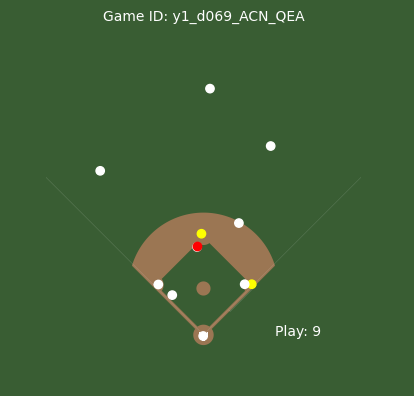

In [24]:
# Courtesy of Eddie Dew's work in animation.py
from Animation import plot_animation

# Filter player position data to the specific game that we want to focus on
player_position_df = player_position_subset.to_table(filter = (pads.field('game_str') == "y1_d069_ACN_QEA")).to_pandas()

# Read in ball position data and filter to same game as player_position
ball_position_subset = readDataSubset('ball_pos')
ball_position_df = ball_position_subset.to_table(filter = (pads.field('game_str') == "y1_d069_ACN_QEA")).to_pandas()

# Animate play
# Arguments are player_pos, ball_pos, play_id, and whether we want to save the animation afterwards
plot_animation(player_position_df, ball_position_df, 9, False)

In [26]:
Player1CatchesWithTimestamps.to_csv("CF-Route-Distance-Comparison.csv",index=False)